In [ ]:
# Author: Boccardi Francesca

# **Image Deblurring**

Given a set of images, the task consists in removing gaussian blur and gaussian noise from them.

Out of all the models that have been developed to deal with the problem, in this notebook only two different approaches will be presented. 

**Due to better performances and results, the final network formally chosen to actually solve the task is the Win5-RB model.** The CAE model is instead shown only for comparison purposes.

## **Dataset creation**

The dataset is built starting from CIFAR-10 images collection. In particular, each image has been corrupted by gaussian blur and gaussian noise.

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import  Input, Conv2D, BatchNormalization, Activation, ReLU, Add, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

The dataset is donwloaded using the predefined `getDataset()` function, which returns the pairs of blurred and clean images for both the train and the test set.

In [ ]:
(blurred_train, original_train), (blurred_test, original_test) = getDataset()

170508288/170498071 [==============================] - 2s 0us/step


## **Data visualization**

To better understand the entity of noise and blur, it is useful to have a look at data.
The first row contains clean original images, while in the second row, for each of them, the correspondent blurred version is shown.

In [ ]:
def show_images(orig, noise, num=20):

    n = num
    plt.figure(figsize=(20, 2))

    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(np.clip(orig[i], 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(np.clip(noise[i], 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

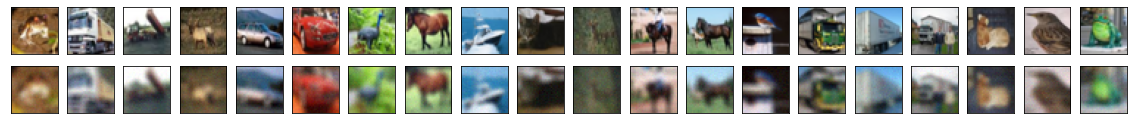

In [ ]:
show_images(original_train, blurred_train)

## **Models**

The literature provides several techniques to deal with the task of image restoration, thus many models can be applied for this purpose. 

In particular, in this notebook two different CNN architectures will be shown and analyzed, comparing respective features, performance and results. 

## **1. Convolutional autoencoder**

The first approach adopted is a **convolutional autoencoder**.


An autoencoder is a network trained to reconstruct input data out of a learned internal representation. In particular, the architecture is composed by an encoder and a decoder: the input data is compressed into latent variables by the encoder and then restored by the decoder, starting from the previously compressed latent variables.

A convolutional autoencoder is a traditional autoencoder where convolutional layers are used in both the encoder and the decoder parts. In deblurring images tasks, the encoder can learn to extract meaningful features from the input blurred image, producing a down-sampled latent image representation. Then, starting from the latent image and performing up-sampling, the decoder can learn to produce a non-noisy reconstruction of the input image.


### **1.1 Network structure**

In this case, the CAE is composed by an encoder and a decoder.

The **encoder** consists of 4 convolutional layers:

* the first 2 layers have 32 and 64 filters respectively, with a 3x3 kernel size, and are both followed by a batch normalization and by the ReLU activation function;
* the last 2 layers have 128 and 256 filters respectively, with a 3x3 kernel size, and are both followed by a batch normalization, the ReLU activation function and a max-pooling subsampling of size 2x2.



The **decoder** instead takes the tensor having sizes (8, 8, 256) from the encoder and passes it through 4 convolutional layers:

* the first 2 layers have 128 and 64 filters respectively, with a 3x3 kernel size, and are both followed by a batch normalization, by the ReLU activation function and an up-sampling layer of size 2x2;
* 1 layer with 32 filters and kernel size 3x3, followed by a batch normalization and the ReLU activation function;
* 1 layer of size (32, 32, 3) and kernel size 3x3 and followed by the sigmoid activation function, which actually outputs the final clean image. 




<center>
<img src='https://drive.google.com/uc?export=view&id=1YDWLgsDldTRZUkTzhDFL3rCTpdHt2Jw8'>
</center>

In [ ]:
def CAE():

      input_img = Input(shape=(32, 32, 3))

      x = Conv2D(32, (3, 3), padding='same')(input_img)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(64, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(128, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = MaxPooling2D((2, 2))(x)

      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      encoded = MaxPooling2D((2, 2))(x)


      x = Conv2D(128, (3, 3), padding='same')(encoded)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = UpSampling2D((2, 2))(x)

      x = Conv2D(64, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = UpSampling2D((2, 2))(x)

      x = Conv2D(32, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(3, (3, 3), padding='same')(x)
      decoded = Activation('sigmoid')(x)

      return Model(input_img,decoded)

The model is then created, using the `CAE()`function. Through the `summary()` function, the whole network structure can be appreciated.

In [ ]:
CAE_model = CAE()
CAE_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

The network counts 779.395 total parameters.

### **1.2 Training**

The model is compiled, defining the Mean Squared Error as loss function and setting Adam as optimizer, with learning rate equal to $0.001$. The optimizer is meant to minimize the mean squared error between the output produced by the network starting from the blurred image and the clean one.


Fitting the model on the training set, the training phase starts. It is set to perform 20 epochs with a batch size equal to 32 (default value), using 10% of the training data as validation set, in order to monitorate potential overfitting or underfitting. The whole train is saved in an history variable, which keeps trace of the MSE behavior of both the training and validation set.

In [ ]:
CAE_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics='mse')
CAE_history = CAE_model.fit(blurred_train, original_train,
          epochs=20,
          validation_split = 0.1,
          verbose=1)

Epoch 1/20
1407/1407 [==============================] - 34s 16ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/20
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 3/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/20
1407/1407 [==============================] - 22s 15ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/20
1407/1407 [==============================] - 22s 15ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 6/20
1407/1407 [==============================] - 22s 15ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/20
1407/1407 [==============================] - 22s 15ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/20
1407/1407 [==========================

After 20 epochs, the network achieves an MSE value approximately equal to 0.0027 over the training set and 0.0028 over the validation set. In particular, the training loss keeps decreasing at each step till the $10^{th}$ epoch, after which the model still does some but little and slower improvements.

From several experiments, it turned out that increasing the number of epochs would let the model to slighty decrease the loss, but the entity of the improvement does not justify the growth in time and computational cost that extending the training would require.

The model doesn't show overfitting, as the loss of both the training and validation set follow an overall descending trend, but val_mse values have a little oscillating behaviour. 

To precisely understand how the model performs on the test set, its evaluation on the test data can be printed.

In [ ]:
CAE_model.save_weights('CAE_model_weights.h5')
CAE_model.save('CAE_model.h5')

In [ ]:
CAE_eval = CAE_model.evaluate(blurred_test, original_test)
print("The MSE value of CAE model on the test set is", CAE_eval[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.0028 - mse: 0.0028
The MSE value of CAE model on the test set is 0.0028164717368781567


The MSE loss value on the test set is really close to the training set one, meaning that, even with only 20 epochs of training, the model results to be robust.

### **1.3 Plot and performance evaluation**

In order to analyze the MSE trend of training and validation set over the epochs, it can be useful to generate a plot, exploiting the history variable previously saved. 

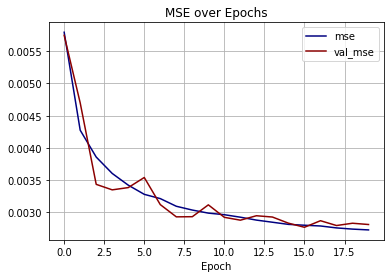

In [ ]:
plt.plot(CAE_history.history['loss'], 'navy')
plt.plot(CAE_history.history['val_loss'], 'darkred')
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'val_mse'])
plt.title('MSE over Epochs')
plt.show()

Using the `predict()` function, the trained network is able to generate the output prediction of the input samples, the input samples being the test set of blurred images.

In [ ]:
CAE_predict = CAE_model.predict(blurred_test)

### **1.4 Qualitative results**

To qualitative appreciate the performance of the model, a visual comparison between the reconstructed and the original images can be done.

In [ ]:
def show_comparison_CAE(n):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    f.set_figheight(20)
    f.set_figwidth(12)

    plt.sca(axarr[0])
    plt.imshow(np.clip(blurred_test[n], 0, 1)); plt.title('Blurred image')
    plt.sca(axarr[1])
    plt.imshow(np.clip(original_test[n], 0, 1)); plt.title('Original image')
    plt.sca(axarr[2]) 
    plt.imshow(np.clip(CAE_predict[n], 0, 1)); plt.title('CAE prediction')
    plt.show()

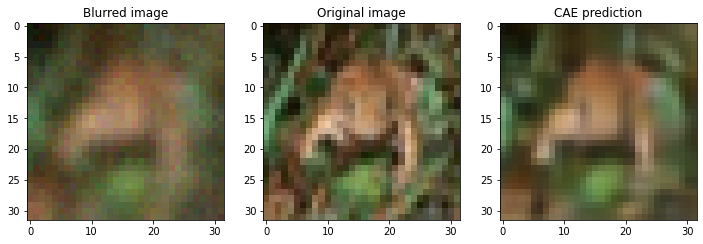

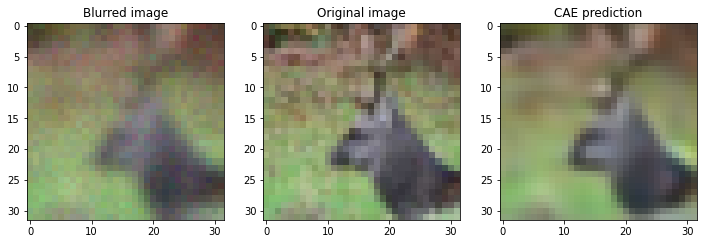

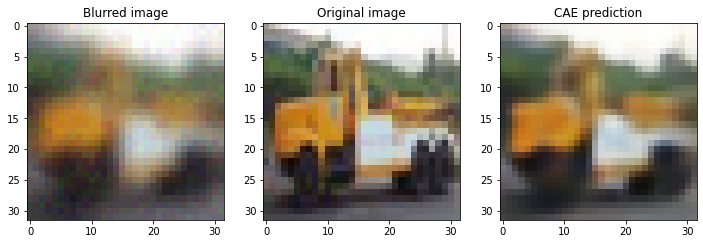

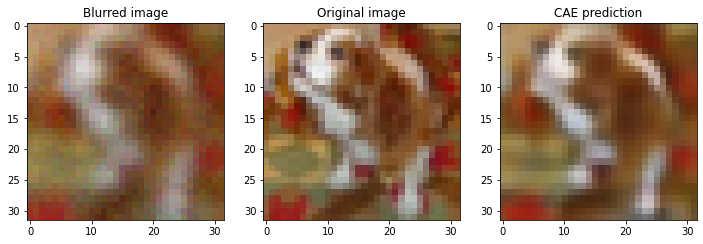

In [ ]:
show_comparison_CAE(np.random.randint(0,blurred_test.shape[0]))
show_comparison_CAE(np.random.randint(0,blurred_test.shape[0]))
show_comparison_CAE(np.random.randint(0,blurred_test.shape[0]))
show_comparison_CAE(np.random.randint(0,blurred_test.shape[0]))

### **2. WIN5-RB**

The second approach adopted relies on **Win5-RB** architecture.

Win5-RB（Wide Inference Network 5layer + Resnet and BatchNormalization）is a model composed by 5 convolutional layers, each of them followed by a ReLU (except for the last layer) and a Batch Normalization. A skip
connection from input-end to output-end is also added to implement residual
learning.

The peculiar attribute of this kind of architecture is the exploitation of the "width" of the network, namely the number of filters and the size of the kernels for each layer, in order to extract more accurate pixel-distribution features through larger receptive fields, even with a shallow structure. 



### **2.1 Network structure**

In this case, the Win5-RB-based network is composed as follows:

* 1 convolutional layer with 32 filters and kernel size 3x3, followed by a batch normalization layer and ReLU activation function;
* 1 convolutional layer with 64 filters and kernel size 5x5, followed by a batch normalization layer and ReLU activation function;
* 2 convolutional layers both with 128 filters and kernel size 7x7, followed by a batch normalization layer and ReLU activation function;
* 1 last convolutional layer with 3 filters and kernel size 7x7, followed by a batch normalization layer.

Finally, a skip connection adding the input to the output of the final layer is included.




<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=13qrPP3t-SM7e48RAuD3ECEPLftK1nlBR'>
</center>
</figure>

A convolutional neural network (CNN) extracts local spatial features from an image and combines the local spatial features to higher-order features.

In particular, through first convolutional layers the network is able to extract local spatial pixel-distribution features and then to combine them to higher-order features with deeper layers. Also, batch normalization is used to speed-up and stabilize the training, as it usually has regularization effects. In addition, the skip connection carries out residual learning and makes up the lost details along convolutions. 
More precisely, considering the original images $x$ and the sum of gaussian noise and blur $η$, the blurred images $y$ to be restored can be expressed as

$$ y = x + η$$


Now, since the final output of the network is achieved by summing up, through the skip connection, the input blurred image with the output of the last Conv+BN layer, namely

$$x_i = y_i + r(y_i)$$


it means that the network has to learn and to fit the residual, namely the opposite of the added noise 

$$r(y_i) ≈ −\eta$$

After several experiments, it turned out to be more efficient to gradually increment the number of filters and the kernel size of convolutional layers, actually doubling the wider layer composed by 128 filters and kernel size 7x7.

In [ ]:
def Win5RB():

    input_0 = Input(shape=(32,32,3), name="input_layer")

    x = Conv2D(32, (3, 3), padding='same')(input_0)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (7, 7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (7, 7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same')(x)
    last = BatchNormalization()(x)

    out = Add()([input_0, last])

    model = Model(input_0, out)

    return model

The model is then created, using the `Win5RB()`function. Through the `summary()` function, the whole network structure can be appreciated.

In [ ]:
Win5RB_model = Win5RB()
Win5RB_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 32)   896         ['input_layer[0][0]']            
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_7[0][

The network counts 1.276.879 total parameters with a depth equal to 5.

### **2.2 Training**

The model is compiled, using quite the same setting as before, namely defining the Mean Squared Error as loss function and setting Adam as optimizer, with learning rate equal to $0.001$. Despite the adaptive nature of Adam optimizer, from several experiments it turned out that adding a learning rate scheduler leads, in this particular case, to improve a bit the performance of the model.

Fitting the model on the training set, the training phase starts. It is set to perform 20 epochs with a batch size equal to 32 (default value), using 10% of the training data as validation set, in order to monitorate potential overfitting or underfitting. The whole train is saved in an history variable, which keeps trace of the MSE behavior of both the train and validation set.

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.5)

In [ ]:
callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler) 

Win5RB_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics='mse')
Win5RB_history = Win5RB_model.fit(blurred_train, original_train,
          epochs=20,
          validation_split = 0.1,
          callbacks=[callback1],
          verbose=1)

Epoch 1/20
1407/1407 [==============================] - 62s 43ms/step - loss: 0.2422 - mse: 0.2422 - val_loss: 0.0095 - val_mse: 0.0095 - lr: 0.0010
Epoch 2/20
1407/1407 [==============================] - 60s 43ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0025 - val_mse: 0.0025 - lr: 0.0010
Epoch 3/20
1407/1407 [==============================] - 60s 43ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0025 - lr: 0.0010
Epoch 4/20
1407/1407 [==============================] - 59s 42ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0025 - lr: 0.0010
Epoch 5/20
1407/1407 [==============================] - 59s 42ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0025 - val_mse: 0.0025 - lr: 0.0010
Epoch 6/20
1407/1407 [==============================] - 59s 42ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0024 - val_mse: 0.0024 - lr: 6.0653e-04
Epoch 7/20
1407/1407 [==============================] - 60s 43ms/step - loss: 0.0023 - mse: 0.0023 - v

After 20 steps it can be noticed that, despite a first bad epoch, the network fastly achieves an MSE value approximately equal to 0.0022. In particular, after the first 7 epochs where the MSE gradually decreases, it stops significantly improving, getting stucked around 0.0022. Also the MSE value computed on the validation set exhibits the same behavior and reaches 0.0023. 

From several experiments it turned out that even with an higher number of epochs, the model would not significantly decrease the MSE value. Also, eventual little improvements would not justify the growth in time and computational cost that extending the training would require.

The model doesn't show overfitting, as the val_mse overall trend follows the training one and its values keep decreasing till 0.0023 is reached, then remaining constant.

In [ ]:
Win5RB_model.save('Win5RB_model.h5')
Win5RB_model.save_weights('Win5RB_model_weights.h5')

To precisely understand how the model performs on the test set, its evaluation on the test data can be printed.

In [ ]:
Win5RB_eval = Win5RB_model.evaluate(blurred_test, original_test)
print("The MSE value of Win5-RB model on the test set is", Win5RB_eval[1])

313/313 [==============================] - 4s 12ms/step - loss: 0.0023 - mse: 0.0023
The MSE value of Win5-RB model on the test set is 0.0022575389593839645


The MSE loss value on the test set is really close to the training set one, meaning that, even with only 20 epochs of training, the model results to be robust.

### **2.3 Plots and performance evaluation** 

In order to analyze the MSE trend of training and validation set over the epochs, it can be useful to generate a plot, exploiting the history variable previously saved. 

For visualization purpose, data are plotted on log-scale and a second graph is shown, where the first epoch loss value has been removed, as it is significantly larger than next ones and doesn't allow to really appreciate the behaviour of the MSE over last epochs.


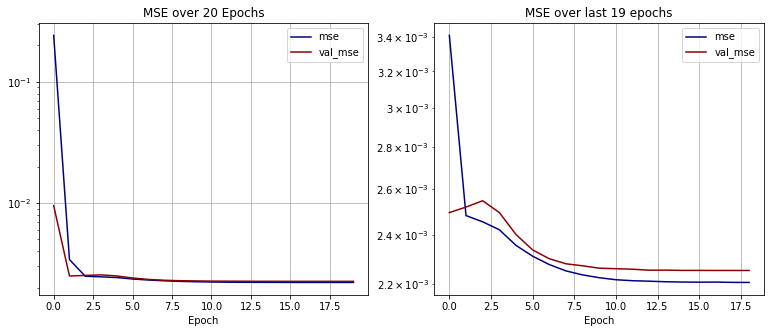

In [ ]:
plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.plot(Win5RB_history.history['loss'], 'navy')
plt.plot(Win5RB_history.history['val_loss'], 'darkred')
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'val_mse'])
plt.title('MSE over 20 Epochs')
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(Win5RB_history.history['loss'][1:], 'navy')
plt.plot(Win5RB_history.history['val_loss'][1:], 'darkred')
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'val_mse'])
plt.title('MSE over last 19 epochs')
plt.yscale("log")
plt.show()

Using the `predict()` function, the trained network is able to generate the output prediction of the input samples, the input samples being the test set of blurred images. 

In [ ]:
Win5RB_predict = Win5RB_model.predict(blurred_test)

### **1.4 Qualitative results**

To qualitative appreciate the performance of the model, a visual comparison between the reconstructed and the original images can be done.

In [ ]:
def show_comparison_Win5RB(n):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    f.set_figheight(20)
    f.set_figwidth(12)

    plt.sca(axarr[0])
    plt.imshow(np.clip(blurred_test[n], 0, 1)); plt.title('Blurred image')
    plt.sca(axarr[1])
    plt.imshow(np.clip(original_test[n], 0, 1)); plt.title('Original image')
    plt.sca(axarr[2]) 
    plt.imshow(np.clip(Win5RB_predict[n], 0, 1)); plt.title('Win5-RB prediction')
    plt.show()

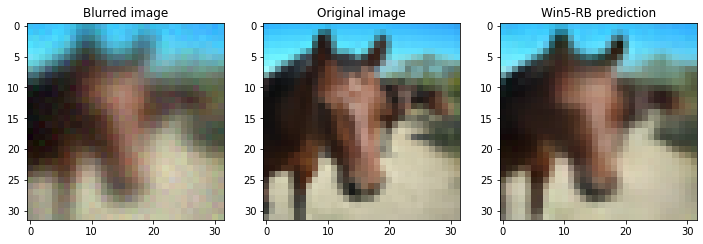

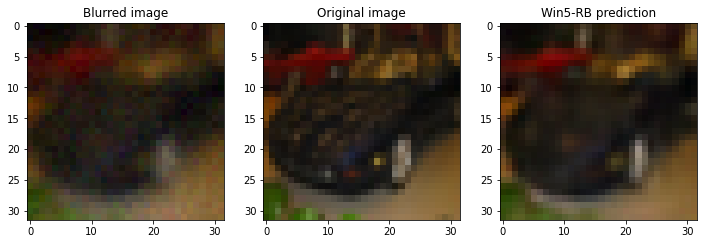

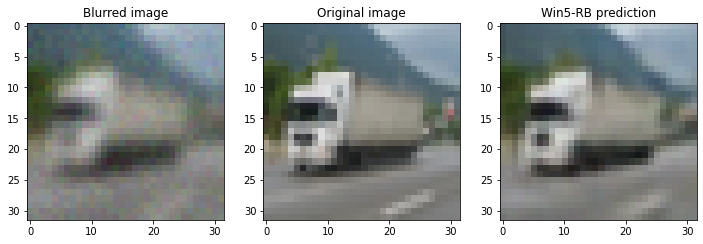

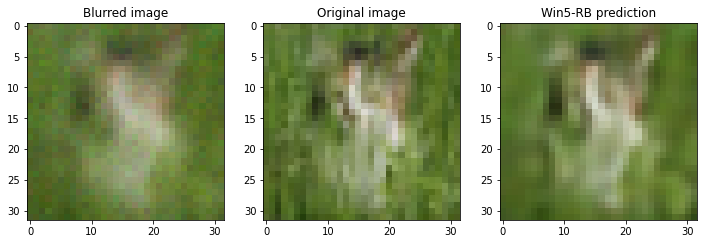

In [ ]:
show_comparison_Win5RB(np.random.randint(0,blurred_test.shape[0]))
show_comparison_Win5RB(np.random.randint(0,blurred_test.shape[0]))
show_comparison_Win5RB(np.random.randint(0,blurred_test.shape[0]))
show_comparison_Win5RB(np.random.randint(0,blurred_test.shape[0]))

## **Models comparison**

In order to compare the two models results, let's print their respective evaluations on the test set.

In [ ]:
print("The evaluation of the CAE model on the test set is", CAE_eval[1])
print("The evaluation of Win5-RB model on the test set is", Win5RB_eval[1])

The evaluation of the CAE model on the test set is 0.0028164717368781567
The evaluation of Win5-RB model on the test set is 0.0022575389593839645


It can be noticed that the Win5-RB network achieves better results, as its MSE value over the test set is the smallest between the two models.


### **Qualitative results**

In order to qualitative observe and analyze differences, a visual comparison between the reconstructed images of both the models can be done.

In [ ]:
def show_comparison(n):
    f, axarr = plt.subplots(nrows=1,ncols=4)
    f.set_figheight(20)
    f.set_figwidth(12)

    plt.sca(axarr[0])
    plt.imshow(np.clip(blurred_test[n], 0, 1)); plt.title('Blurred image')
    plt.sca(axarr[1])
    plt.imshow(np.clip(original_test[n], 0, 1)); plt.title('Original image')
    plt.sca(axarr[2]) 
    plt.imshow(np.clip(CAE_predict[n], 0, 1)); plt.title('CAE prediction')
    plt.sca(axarr[3]) 
    plt.imshow(np.clip(Win5RB_predict[n], 0, 1)); plt.title('Win5-RB prediction')
    plt.show()

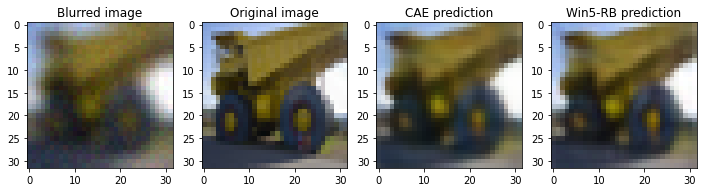

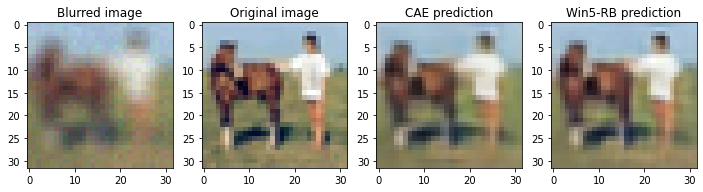

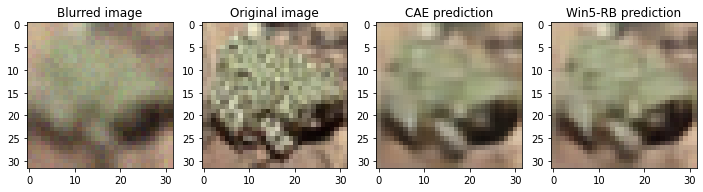

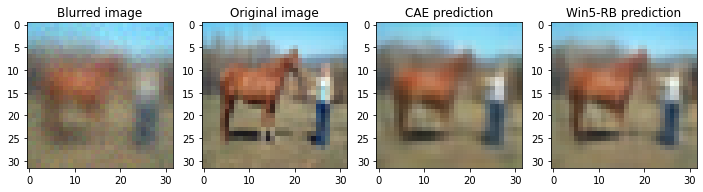

In [ ]:
show_comparison(np.random.randint(0,blurred_test.shape[0]))
show_comparison(np.random.randint(0,blurred_test.shape[0]))
show_comparison(np.random.randint(0,blurred_test.shape[0]))
show_comparison(np.random.randint(0,blurred_test.shape[0]))

## **Conclusions**

Finally, out of all the models that have been implemented to deblurred images, Win5-RB model achieves the best results. In addition, its training takes a reasonable amount of time and perfoms well in only 20 epochs, without any sign of overfitting, which underlines its robustness also in prediction of images out of the training set. Thus, it is the final model actually chosen to deal with the task of deblurring images.

## **References**

*Autoencoders*: https://blog.paperspace.com/understanding-autoencoders/

*CAE*: http://cs231n.stanford.edu/reports/2017/pdfs/328.pdf

*Win5-RB*: https://arxiv.org/pdf/1707.09135.pdf